# Simon's Problem
Jeries Dababneh and Esteban Duran

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from sympy import *
%matplotlib inline

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, execute
from qiskit.tools.visualization import plot_histogram

import warnings
warnings.simplefilter('ignore')

In [34]:
def simons_circuit(qbits, secret):
    n = qbits

    qr = QuantumRegister(n*2) # 4 qubit register
    cr = ClassicalRegister(n) # 1 classical register
    circ = QuantumCircuit(qr, cr) # Quantum Circuit on q

    for i in range(0, n):
        circ.h(qr[i])

    circ.barrier()

    for i in range(0, n):
        circ.cx(qr[i], qr[n+i])

    circ.barrier()

    s = secret

    #xor s.
    for i, c in enumerate(s):
        if c == '0':
            circ.cx(qr[i], qr[n+i])

    circ.barrier()
    
    for i in range(0, n):
        circ.h(qr[i])
        circ.measure(qr[i], cr[i])
        
    return circ

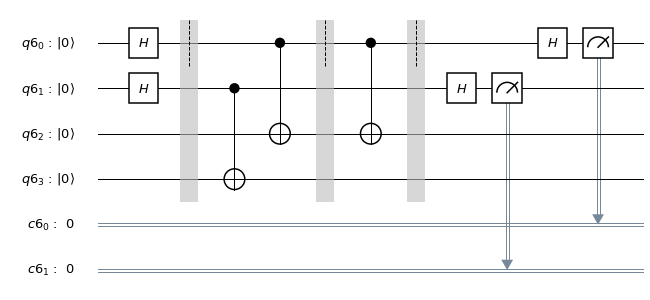

In [63]:
n = 2
secret = '01'
circ = simons_circuit(n, secret)
circ.draw(output='mpl')

In [4]:
# turn the measured string into an array of integers.
def get_wi(w):
    v = []
    for i in range(n):
        v.append(int(w[(n-i) - 1]))
    return v

In [58]:
simulator = Aer.get_backend('qasm_simulator')
M = Matrix([[]])

#while loop to collect the rest
dim = 0
i = 0
count = {}
while(True and i < 2*n ):
    #run simul, get measurement
    result = execute(circ, simulator, shots=1).result()
    temp = result.get_counts(circ)
    mes = next(iter(temp))
    if int(mes) != 0:
        wi = get_wi(mes)
        if mes in count:
            count[mes] = count[mes] + 1
        # make augment matrix by adding the new row
        ma = M.col_join(Matrix([wi]))
        
        #check if new measuremnt is in the span of {w_i}
        m, mr = M.rref()
        mA, mar = ma.rref()
        if mr != mar:
            M = ma
            dim = dim + 1
            count[mes] = 1
        if (dim == n - 1):
            break     
    i = i + 1
M, _ = M.rref()
#ptrint the system of equations that satisfy s
rows, cols = M.shape
for r in range(rows):
    Yr = [ "s[ "+str(i)+" ]" for i, v in enumerate(list(M[r,:])) if v == 1 ]
    if len(Yr) > 0:
        tStr = " + ".join(Yr)
        print(tStr, "= 1")
M

s[ 1 ] = 1
s[ 2 ] = 1
s[ 3 ] = 1


Matrix([
[0, 1, 0, 0],
[0, 0, 1, 0],
[0, 0, 0, 1]])

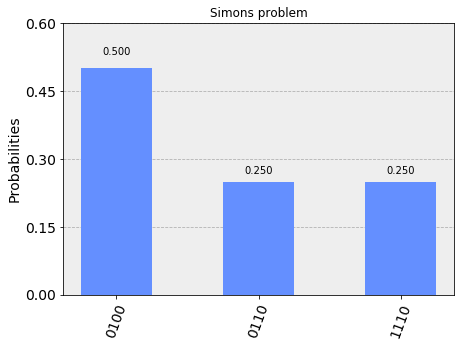

In [59]:
plot_histogram(count, title='Simons problem')

In [43]:
count

{'001000': 4, '001010': 2, '000100': 3, '001100': 1, '000110': 1}

In [53]:
from qiskit import IBMQ
IBMQ.load_accounts()

In [54]:
print("Available backends:")
IBMQ.backends()

Available backends:


[<IBMQBackend('ibmqx4') from IBMQ()>,
 <IBMQBackend('ibmqx2') from IBMQ()>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ()>,
 <IBMQBackend('ibmq_qasm_simulator') from IBMQ()>]

In [74]:
from qiskit.providers.ibmq import least_busy

large_enough_devices = IBMQ.backends(filters=lambda x: x.configuration().n_qubits > 3 and not x.configuration().simulator)
backend = least_busy(large_enough_devices)
print("The best backend is " + backend.name())

The best backend is ibmqx4


In [64]:
from qiskit.tools.monitor import job_monitor
shots = 50*n
max_credits = 3
job_exp = execute(circ, backend, shots = shots, max_credits=max_credits)

In [ ]:
job_monitor(job_exp)

In [ ]:
res = job_exp.result()
answer = res.get_counts(circ)

plot_histogram(answer)